# Training Meta-Value vs itself/naive/LOLA

# Imports

In [14]:
import dataclasses, pickle, os, sys, time
from functools import partial
from pathlib import Path
import numpy as np
import jax, jax.numpy as jp, jax.random as rax, jax.tree_util as tu
import flax, flax.linen as nn, flax.serialization, flax.struct as struct
import matplotlib.pyplot as plt

stop = jax.lax.stop_gradient
deepmap = tu.tree_map

# Utilities

In [15]:
def take_about(k, xs):
  ys = [xs[i] for i in np.unique(np.round(np.linspace(0, len(xs) - 1, k)).astype("int"))]
  return ys
def eqzip(*xss):
  xss = list(map(list, xss))
  assert all(len(xs) == len(xss[0]) for xs in xss)
  return list(map(list, zip(*xss)))
def unzip2(xss):
  if not xss: return [], []
  return eqzip(*xss)
def rscope(rng, *path):
  # NOTE used to use seed = hash(path) but that is nondeterministic
  import zlib
  data = "/".join(map(str, path)).encode("ascii")
  seed = zlib.crc32(data)
  return rax.fold_in(rng, seed)
def params_rscope(rng, params):
  return flax.core.freeze(map_nested_dict(lambda path, param: rscope(rng, "/".join(map(str, path))),
                                          params))

def quantile_regression_loss(xs, ys):
  [n] = ys.shape
  mid = (jp.arange(n) + 0.5) / n  # quantile midpoints
  dq = ys[None, :] - xs[:, None]
  loss = jp.abs(mid[:, None] - (dq<0)) * huber(dq)
  return loss.sum() / n

def huber(delta, threshold=1):
  delta = jp.abs(delta)
  return jp.where(delta <= threshold,
                  delta ** 2 / 2,
                  threshold * delta - threshold ** 2 / 2)

def value_and_naive_gradients(f):
  def fn(agents):
    y, df = jax.vjp(f, agents)
    [dydx] = jax.vmap(df)(jp.eye(2,dtype="float32"))
    dx = jp.einsum("ii...->i...", dydx)
    return y, dx
  return fn
def naive_gradients(f):
  def fn(agents):
    y, dx = value_and_naive_gradients(f)(agents)
    return dx
  return fn

from collections import abc
def iterate_nested_dict(node):
  if not isinstance(node, abc.Mapping):
    yield (), node
  else:
    for key, child in node.items():
      for path, leaf in iterate_nested_dict(child):
        yield (key, *path), leaf
def map_nested_dict(fn, node, path=()):
  if not isinstance(node, abc.Mapping):
    return fn(path, node)
  return {
    key: map_nested_dict(fn, child, (*path, key))
    for key, child in node.items()
  }
def map_params_dict(fn, node):
  return flax.core.freeze(map_nested_dict(fn, node))

In [16]:
@struct.dataclass
class VHatParameters:
  params: "Any"
  module: "Module" = struct.field(pytree_node=False)

  def __call__(self, agents, **kwargs):
    x = self.module.apply(dict(params=self.params), agents, **kwargs)
    return x.mean(axis=-1)

  def quantiles(self, agents, **kwargs):
    return self.module.apply(dict(params=self.params), agents, **kwargs)

  @classmethod
  def init(cls, module, rng):
    params = module.init(rng, init_agents(rax.PRNGKey(1)), gamma=jp.zeros([2], dtype="float32"))["params"]
    return cls(params, module)

  def rscope(self, rng):
    return self.replace(params=params_rscope(rng, self.params))
  def describe(self):  # show parameter shapes and sizes
    print("vhat params")
    for path, param in iterate_nested_dict(self.params):
      print("  ", "/".join(map(str, path)), param.shape, param.size)
    print("total vhat params", sum(param.size for param in tu.tree_leaves(self.params)))

@struct.dataclass
class AdamOptimizer:
  lr: float = struct.field(pytree_node=False, default=1e-3)
  eps: float = struct.field(pytree_node=False, default=1e-8)
  beta1: float = struct.field(pytree_node=False, default=0.9)
  beta2: float = struct.field(pytree_node=False, default=0.99)
  clip: "Any" = struct.field(pytree_node=False, default=None)
  decay: float = struct.field(pytree_node=False, default=0.01)
  moment1: "Any" = None
  moment2: "Any" = None
  n: int = 0

  @classmethod
  def make_for(cls, params, **hp):
    moment1 = deepmap(jp.zeros_like, params)
    moment2 = deepmap(jp.zeros_like, params)
    return cls(moment1=moment1, moment2=moment2, n=jp.array(0, dtype="int32"), **hp)

  def __call__(self, params, grad):
    if self.clip is not None:
      grad = deepmap(lambda dx: jp.clip(dx, -self.clip, +self.clip), grad)
    moment1 = deepmap(lambda m,dx: m + (1-self.beta1)*(dx-m), self.moment1, grad)
    moment2 = deepmap(lambda m,dx: m + (1-self.beta2)*(dx**2-m), self.moment2, grad)
    n = self.n + 1
    dbmoment1 = deepmap(lambda m: m / (1-self.beta1**n), moment1)
    dbmoment2 = deepmap(lambda m: m / (1-self.beta2**n), moment2)
    step = deepmap(lambda dm1,dm2,x: (self.lr*(dm1/(self.eps+dm2**0.5))
                                      -jp.abs(self.lr)*self.decay*x),
                   dbmoment1, dbmoment2, params)
    new_self = self.replace(moment1=moment1, moment2=moment2, n=n)
    return new_self, step

def apply_grads(optimizers, modules, grads):
  optimizers, steps = unzip2(opt(m, grad) for opt, m, grad in eqzip(optimizers, modules, grads))
  new_modules = [deepmap(lambda x, dx: x + dx, module, step)
                 for module, step in eqzip(modules, steps)]
  return optimizers, new_modules

# Configuration

In [17]:
GAME_DISCOUNT = 0.96
GAME_STRUCTURE = "ipd" # ipd/chicken/imp
PAYOFF_MATRICES = dict(
  ipd=np.array([[-2,0,-3,-1], [-2,-3,0,-1]]).T,  # [state, player]
  imp=np.array([[+1,-1,-1,+1], [-1,+1,+1,-1]]).T,
  chicken=np.array([[-100,+1,-1,0], [-100,-1,+1,0]]).T,
)
PAYOFFS = PAYOFF_MATRICES[GAME_STRUCTURE]
OPPONENT = "meva" # naive/lola/meva

@struct.dataclass
class Hp:
  outer_lr: float = 1e-3
  alpha: float = 1 if GAME_STRUCTURE == "chicken" else 1/(1-GAME_DISCOUNT)
  outer_num_steps: int = 1001
  inner_num_steps: int = 100
  stride: int = 10
  batch_size: int = 128
  rho: float = 0.99
  seed: int = 1
  explore_policy: str = "noisy_vhat"
  correction_version: int = 1  # agents follow grad(f+gamma V), V=f'+gamma V'
  quantiles: int = 64

def draw_gamma(rng, shape=()):
  return rax.beta(rng, 0.5, 0.5, shape=shape)  # arcsin distribution

# during training, we maintain "outer agents" -- agents that follow gradients of
# the model without any exploration and with fixed gamma. this allows us to
# monitor the performance while training.
OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "90 95 99".split()}
OAGENT_GAMMAS = {s: float(f"0.{s}") for s in "99".split()}

# Game definition

In [18]:
def play_episode(agents, discount=GAME_DISCOUNT, payoffs=PAYOFF_MATRICES[GAME_STRUCTURE]):
  pi = nn.sigmoid(agents)
  assert pi.shape == (2,5)
  pi = pi.at[1].set(pi[1,(0,1,3,2,4)])  # swap player 2 perspective
  pi = jp.stack([1-pi,pi], axis=-1) # [player, state, action]
  p0 = jp.einsum("a,b->ab", pi[0,0], pi[1,0]).reshape([4]) # initial state distribution
  P = jp.einsum("sa,sb->sab", pi[0,1:], pi[1,1:]).reshape([4,4])  # transition matrix
  I = jp.eye(4)
  effective_state = (1-discount)*p0@jp.linalg.inv(I-discount*P)
  returns = effective_state@payoffs
  return dict(returns=returns, effective_state=effective_state,
              epstats=dict(zip("DD DC CD CC".split(), effective_state)))

def init_agents(rng, batch_shape=()):
  return rax.normal(rng, shape=[*batch_shape,2,5])

def f_lola(x, alpha=1/(1-GAME_DISCOUNT)):
  def f(x):
    return play_episode(x)["returns"]
  if alpha == 0:
    return f(x)
  x_extra = x + alpha * naive_gradients(f)(x)
  return jp.stack([
      f(jp.stack([x[0], x_extra[1]]))[0],
      f(jp.stack([x_extra[0], x[1]]))[1],
  ])

# Architecture

In [19]:
class VHat(nn.Module):
  size: int = 128
  normalize: int = 1
  equivariant: int = 1
  quantiles: int = 64

  @nn.compact
  def __call__(self, agents, gamma, explore_rng=None, explore_level=0.):
    zpolicy = nn.sigmoid(agents)  # [player, features]
    zpolicy = nn.gelu(nn.Dense(self.size, name="embed")(zpolicy))
    zpolicy = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="zpolicy")(zpolicy))

    zgamma = nn.gelu(nn.Dense(self.size, name="zgamma")(gamma[:,None]))

    z = jp.concatenate([zpolicy, zgamma], axis=-1)

    if not self.equivariant:
      # players are following different learning algorithms, so we can't quite use
      # our equivariant parameterization. give the model a non-equivariant scale
      # and bias so it can distinguish the two players.
      z = (z * self.param("zscale", nn.initializers.ones, z.shape)
           + self.param("zbias", nn.initializers.zeros, z.shape))

    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_gamma")(z))
    for layer in range(1):
      z = ResidualBlock(name=f"Q{layer}", normalize=self.normalize)(z)
    z = jp.concatenate([z, z[::-1]], axis=-1)
    z = nn.gelu(DenseNorm(self.size, normalize=self.normalize, name="mix_oppt")(z))
    for layer in range(1):
      z = ResidualBlock(name=f"R{layer}", normalize=self.normalize)(z)
    z = nn.tanh(DenseNorm(self.size, normalize=self.normalize, name="zfinal")(z))

    if explore_rng is not None: # flip sign on units to vary vhat for use in explore
      keep_prob = 1 - explore_level/2
      mask = rax.bernoulli(rscope(explore_rng, "latent_mask"), p=keep_prob, shape=z.shape)
      z = jp.where(mask, z, -z)  # [player, features]
    return nn.Dense(self.quantiles, name="output")(z) # [player, quantiles]

class DenseNorm(nn.Module):
  size: int
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    z = nn.Dense(self.size, kernel_init=nn.initializers.orthogonal(),
                 name="d", use_bias=not self.normalize)(x)
    if self.normalize:
      z = nn.LayerNorm(name="n")(z)
    return z

class ResidualBlock(nn.Module):
  normalize: int = 0

  @nn.compact
  def __call__(self, x):
    size = x.shape[-1]
    z = nn.gelu(DenseNorm(size, name="X", normalize=self.normalize)(x))
    y = nn.Dense(size, name=f"H")(z)
    gate = nn.sigmoid(self.param("G", nn.initializers.zeros, [z.shape[-1]]))
    return gate*x + (1-gate)*y

# Training functions

In [20]:
@struct.dataclass
class TrainState:
  step: int
  flat_step: int
  rng: "PRNGKey"
  vhat: "VHatParameters"
  target_vhat: "VHatParameters"
  optimizer: "AdamOptimizer"
  oagentss: "List[array(batch,2,5)]"

  @classmethod
  def make(cls, hp):
    rng = rax.PRNGKey(hp.seed)
    oagentss = cls._init_oagents(rscope(rng, "init_oagents"), hp)
    vhat = VHatParameters.init(VHat(quantiles=hp.quantiles, equivariant=OPPONENT == "meva"), rng=rng)
    optimizer = AdamOptimizer.make_for(vhat, lr=-hp.outer_lr)
    target_vhat = vhat.replace(params=deepmap(jp.array, vhat.params))
    state = cls(step=jp.array(0), flat_step=jp.array(0), rng=rscope(rng, "train"),
                vhat=vhat, target_vhat=target_vhat, optimizer=optimizer,
                oagentss=oagentss)
    return state

  def pop_rng(self):
    rng, elt = rax.split(self.rng)
    return self.replace(rng=rng), elt

  @classmethod
  def _init_oagents(cls, rng, hp):
    # for each OAGENT_GAMMAS, init a stacked batch of agents
    oagentss = [init_agents(rscope(rng, gammastr), [hp.batch_size])
                for gammastr, gamma in OAGENT_GAMMAS.items()]
    return oagentss
  def reset_oagents(self, rng, hp):
    oagentss = self._init_oagents(rng, hp)
    return self.replace(oagentss=oagentss)

def get_grads(vhat, agents):
  if OPPONENT == "naive":
    gradA = jax.grad(lambda x: vhat(x)[0])(agents)[0]
    gradB = jax.grad(lambda x: f_lola(x, alpha=0)[1])(agents)[1]
    grads = jp.stack([gradA, gradB])
  elif OPPONENT == "lola":
    gradA = jax.grad(lambda x: vhat(x)[0])(agents)[0]
    gradB = jax.grad(lambda x: f_lola(x)[1])(agents)[1]
    grads = jp.stack([gradA, gradB])
  elif OPPONENT == "meva":
    grads = naive_gradients(vhat)(agents)
  return grads

def train(hp):
  def do_episode(agents, rng=None):
    episode = play_episode(agents)
    return episode["returns"], episode

  def prepare_vhat(vhat, gamma, context):
    vhat = partial(vhat, gamma=gamma)
    if not hp.correction_version: return vhat
    if context == "iagents": return vhat # just use vhat for explore
    def fn(agents):
      f, episode = do_episode(agents)
      vnext = vhat(agents)
      return (1-gamma)*f+gamma*vnext
    return fn

  @partial(jax.jit, donate_argnums=(1,))
  def update_iagents(ostate, istate, rng, gamma, explore_rng):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma, explore_rng):
      explore_level = 0.125
      vhat = dict(vhat=ostate.vhat,
                  target_vhat=ostate.target_vhat,
                  noisy_vhat=partial(ostate.vhat,
                                     explore_rng=rscope(explore_rng, "noisy_vhat"),
                                     explore_level=explore_level),
                  noisy_target_vhat=partial(ostate.target_vhat,
                                            explore_rng=rscope(explore_rng, "noisy_vhat"),
                                            explore_level=explore_level),
      )[hp.explore_policy]
      vhat = prepare_vhat(vhat, gamma, context="iagents")
      return do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)

    istates, epauxes = fn(istate, rax.split(rscope(rng, "inner_transition"), hp.batch_size),
                          gamma, rax.split(explore_rng, hp.batch_size))
    loss_fn = get_loss_fn(ostate, istates, [epaux["f"] for epaux in epauxes], gamma)
    loss, lossaux = loss_fn(ostate.vhat, rscope(rng, "model"))

    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               td=lossaux["td"], loss=loss, v=lossaux["v"])
    return istates[-1], aux

  @jax.jit
  def update_vhat(ostate, istate, rng, gamma):
    @jax.vmap  # policy batch
    def fn(istate, rng, gamma):
      vhat = prepare_vhat(ostate.vhat, gamma, context="vhat")
      istates, epauxes = do_inner_transitions(istate, vhat, rscope(rng, "inner_transition"), hp.stride)
      fs = [epaux["f"] for epaux in epauxes]
      return istates, epauxes, fs

    istates, epauxes, fs = fn(istate, rax.split(rscope(rng, "inner_transitions"), hp.batch_size), gamma)
    loss_fn = get_loss_fn(ostate, istates, fs, gamma)
    (loss, lossaux), grad = jax.value_and_grad(loss_fn, has_aux=True)(ostate.vhat, rscope(rng, "model"))
    new_optimizer, dvhat = ostate.optimizer(ostate.vhat, grad)
    new_vhat = deepmap(lambda x,dx:x+dx, ostate.vhat, dvhat)
    new_target_vhat = deepmap(lambda xbar,x: xbar+(1-hp.rho)*(x-xbar), ostate.target_vhat, new_vhat)

    new_ostate = ostate.replace(optimizer=new_optimizer, vhat=new_vhat, target_vhat=new_target_vhat)
    aux = dict(epstats=epauxes[0]["epstats"], f=epauxes[0]["f"],
               loss=loss, td=lossaux["td"], v=lossaux["v"],
               gradnorms=deepmap(lambda x: (x**2).mean(), grad))
    return new_ostate, aux

  def update_oagents(ostate, rng):
    new_oagentss = []; auxes = dict()
    for (gammastr, gamma), agents in eqzip(OAGENT_GAMMAS.items(), ostate.oagentss):
      new_agents, aux = _update_oagents(agents, ostate.target_vhat, rscope(rng, gammastr), gamma)
      new_oagentss.append(new_agents)
      auxes[gammastr] = aux
    return ostate.replace(oagentss=new_oagentss), auxes
  @partial(jax.jit, donate_argnums=(0))
  def _update_oagents(agents, vhat, rng, gamma):
    vhat = prepare_vhat(vhat, jp.full([2], gamma), context="oagents")
    @jax.vmap
    def fn(agents, rng):
      f, episode = do_episode(agents, rscope(rng, "episode"))
      grads = get_grads(vhat, agents)
      agents = agents + hp.alpha * grads
      return agents, dict(episode=episode, epstats=episode["epstats"], f=f)
    return fn(agents, rax.split(rng, hp.batch_size))

  def do_inner_transitions(x, vhat, rng, n):
    xs = [x]; auxes = []
    for i in range(n):
      f, episode = do_episode(x)
      grads = get_grads(vhat, x)
      x = x + hp.alpha * grads
      xs.append(x)
      auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    f, episode = do_episode(x)
    auxes.append(dict(f=f, episode=episode, epstats=episode["epstats"]))
    return xs, auxes

  def get_loss_fn(ostate, istates, fs, gamma):
    def loss_fn_single(vhat, ostate, istates, fs, gamma):
      fs = fs[1:] if hp.correction_version else fs[:-1]

      T = len(istates)
      assert len(fs) + 1 == T
      rewards = jp.stack(fs) # [time,player]
      xs = deepmap(lambda *xs: jp.stack(xs), *[x for x in istates])  # agents with leading time axis
      vs = jax.vmap(partial(vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]
      tvs = jax.vmap(partial(ostate.target_vhat.quantiles, gamma=gamma))(xs)  # [time,player,quantiles]

      lamda = 0.9   # compute lamda-return by reverse scan
      gg = gamma[...,None]
      def body_fn(target, inputs):
        [r,tv] = inputs
        target = (1-gg)*r + gg*((1-lamda)*tv+lamda*target)
        return target,target
      _, targets = jax.lax.scan(body_fn, tvs[-1], [rewards[::-1,...,None],tvs[1:][::-1]])
      targets = targets[::-1]
      predictions = vs[:-1]

      loss = jax.vmap(jax.vmap(quantile_regression_loss))(predictions, targets) # across time,player
      td = (predictions-targets).mean(axis=-1) # across quantiles
      assert loss.shape == td.shape  # [time,player]

      return loss.mean(), dict(v=vs[0].mean(axis=-1), td=td[0])

    def loss_fn(vhat, rng):
      loss, aux = jax.vmap(partial(loss_fn_single, vhat, ostate))(istates, fs, gamma)
      return loss.mean(), aux
    return loss_fn

  def try_exploit(candidate, rng, nsteps=300): # train a naive agent against fixed candidate
    opponent = init_agents(rscope(rng, "init"))[0]
    assert opponent.shape == (5,)
    for step in range(nsteps):
      rng, steprng = rax.split(rng)
      opponent, f = _try_exploit_step(candidate, opponent, steprng)
    return dict(f=f, opponent=opponent)
  @jax.jit
  def _try_exploit_step(candidate, opponent, rng):
    def objective(opponent):
      agents = jp.stack([candidate, opponent])
      f, episode = do_episode(agents, rng)
      return f[1], dict(episode=episode, epstats=episode["epstats"], f=f)
    (_, aux), grad = jax.value_and_grad(objective, has_aux=True)(opponent)
    new_opponent = opponent + hp.alpha * grad
    return new_opponent, aux["f"]

  log = []
  ostate = TrainState.make(hp)
  while ostate.step < hp.outer_num_steps:
    ostate, rng = ostate.pop_rng()

    isteps = list(range(0, hp.inner_num_steps, hp.stride))
    init_irng, *irngs = rax.split(rscope(rng, "inner_init"), 1 + len(isteps))
    istate = init_agents(rscope(init_irng, "agents"), [hp.batch_size])
    gamma_explore = draw_gamma(rscope(init_irng, "gamma"), shape=[hp.batch_size,2])
    explore_rng = rscope(init_irng, "explore")

    for istep, irng in eqzip(isteps, irngs):
      # advance inner agents by hp.stride steps
      istate, iaux = update_iagents(ostate, istate, rscope(irng, "update_iagents"), gamma_explore, explore_rng=explore_rng)

      # advance outer agents by as many steps
      for _ in range(hp.stride):
        ostate, oauxes = update_oagents(ostate, rscope(rng, "oagents"))

      ostate, sample_aux = update_vhat(ostate, istate, rscope(irng, "train"),
                                       draw_gamma(rscope(irng, "gamma"), shape=[hp.batch_size,2]))

      ostate = ostate.replace(flat_step=ostate.flat_step + hp.stride)

    log.append(dict(loss=sample_aux["loss"], td=(sample_aux["td"] ** 2).mean()))

    ostate = ostate.replace(step=ostate.step + 1)
    if ostate.step % 100 == 0:
      print(ostate.step)
      # reset outer agents. first, print some information about the final outer agents
      for gammastr, oagents in eqzip(OAGENT_GAMMAS, ostate.oagentss):
        print("  outer agent stats", gammastr)
        oaux = oauxes[gammastr]
        exploit_aux = jax.vmap(try_exploit)(oagents[:,0], rax.split(rax.PRNGKey(1), hp.batch_size))
        print("    returns:", oaux["f"].mean(axis=0))
        print("    returns vs exploiter:", exploit_aux["f"].mean(axis=0))  # (agent2 is trained to exploit agent1)
        print("    expected state (DD DC CD CC):", np.array([oaux["epstats"][key].mean(axis=0) for key in "DD DC CD CC".split()]))
      ostate = ostate.reset_oagents(rscope(ostate.rng, "reset_oagents"), hp)

  return dict(ostate=ostate, log=log, hp=hp)

# Training

Training three seeds takes about half an hour.

In [21]:
import pickle
cache_path = f"drive/MyDrive/metavalue/nbdata/{GAME_STRUCTURE}_meva_vs_{OPPONENT}__postquantilesnameclash"
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p {cache_path}
def cache_load(filename):
  try:
    with open(f"{cache_path}/{filename}.pkl", "rb") as file:
      return pickle.load(file)
  except FileNotFoundError:
    return None
def cache_save(obj, filename):
  with open(f"{cache_path}/{filename}.pkl", "wb") as file:
    pickle.dump(obj, file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!ls {cache_path}

In [23]:
runs = []
for seed in range(5):
  run = cache_load(f"seed{seed}")
  #run = None
  if run is None:
    print("training seed", seed)
    time_start = time.perf_counter()
    run = train(Hp(seed=seed))
    time_end = time.perf_counter()
    print("seconds taken: ", f"{time_end-time_start:.4f}")
    cache_save(run, f"seed{seed}")
  runs.append(run)

training seed 0
100
  outer agent stats 99
    returns: [-1.4472358 -1.4459164]
    returns vs exploiter: [-1.2079378 -1.2645478]
    expected state (DD DC CD CC): [0.43716976 0.00918711 0.009627   0.54401577]
200
  outer agent stats 99
    returns: [-1.0001873 -1.0002087]
    returns vs exploiter: [-1.3414932 -0.9706752]
    expected state (DD DC CD CC): [4.6574255e-06 1.9711461e-04 1.8989171e-04 9.9960786e-01]
300
  outer agent stats 99
    returns: [-1.1082785 -1.1130553]
    returns vs exploiter: [-1.7839316 -0.7583984]
    expected state (DD DC CD CC): [0.02397729 0.0874854  0.08589302 0.8026439 ]
400
  outer agent stats 99
    returns: [-1.2395744 -1.2389817]
    returns vs exploiter: [-0.95261586 -1.0968841 ]
    expected state (DD DC CD CC): [0.05739899 0.18178266 0.1819803  0.5788368 ]
500
  outer agent stats 99
    returns: [-1.4724481 -1.4722551]
    returns vs exploiter: [-0.943077  -1.1160767]
    expected state (DD DC CD CC): [0.36457318 0.10774764 0.10781184 0.41986665]


Text(0.5, 1.0, 'td')

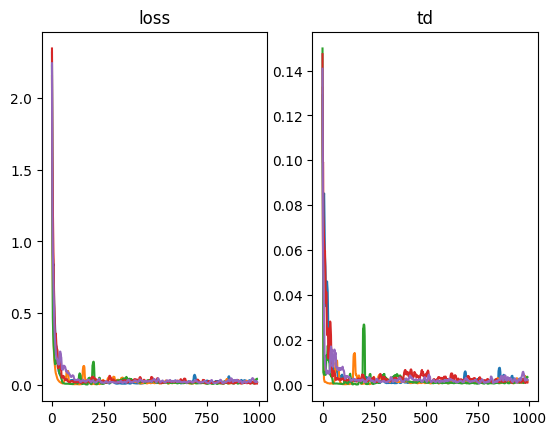

In [24]:
fig, axes = plt.subplots(1,2, sharex=True)
for run in runs:
  seqs = deepmap(lambda *xs: jp.stack(xs), *run["log"])
  seqs = deepmap(lambda xs: np.lib.stride_tricks.sliding_window_view(xs, 10).mean(axis=-1), seqs)
  axes[0].plot(seqs["loss"])
  axes[1].plot(seqs["td"])
axes[0].set_title("loss")
axes[1].set_title("td")

# Analysis

For analysis we train a few batches of agents using the trained models. We train pairs of agents where both follow gradients of the model, then we hold one agent fixed and find the best response to it. Finally we also train pairs of agents where one agent follows gradients of the model and the other is naive, to demonstrate opponent shaping.

This takes about a minute to run.

In [25]:
analysis_batch_size = 2048

def train_agents(rng, vhat, gamma, hp):
  # agent A follows vhat(.;gamma), agent B follows lola
  agents = init_agents(rng, [analysis_batch_size])
  trail = [agents]
  for step in range(500):
    agents = _train_agents_step(vhat, gamma, agents, hp.alpha)
    trail.append(agents)
  return jp.stack(trail, axis=1) #[batch,time,2,5]
@jax.jit
@partial(jax.vmap, in_axes=(None,None,0,None))
def _train_agents_step(vhat, gamma, agents, alpha):
  def prepared_vhat(agents):
    v = vhat(agents, gamma=jp.full([2], gamma))
    if Hp().correction_version:
      episode = play_episode(agents)
      f = episode["returns"]
      return (1-gamma)*f+gamma*v
    else:
      return v
  grads = get_grads(prepared_vhat, agents)
  agents = agents + alpha * grads
  return agents

In [26]:
def train_policies(run, gamma):
  rng = rax.PRNGKey(1)
  agents = train_agents(rscope(rng, "agents"), run["ostate"].target_vhat, gamma, run["hp"]) #[batch,time,2,5]
  return dict(agents=agents)

def evaluate_policies(agents):
  return dict(agents=play_episode(agents)["returns"])

class Analysis:  # just a namespace
  gammastrs = "00 25 50 70 80 90 95 99".split()
  gammas = [float(f"0.{gammastr}") for gammastr in gammastrs]
  trails = dict()
  policies = dict()
  returns = []
  for gammastr, gamma in eqzip(gammastrs, gammas):
    trajectories = []
    for run in runs:
      trajectories.append(train_policies(run, gamma))
    trajectories = {key: jp.stack(list(map(lambda t:t[key], trajectories)), axis=0) # [seed,batch,time,2,5]
                    for trajectories in [trajectories]
                    for key in "agents".split()}
    trails[gammastr] = trajectories
    policies[gammastr] = deepmap(lambda x: x[:,:,-1], trajectories) # policies[gammastr][{agents,responses,shapings}][seed,batch,2,5]
    returns.append(jax.vmap(jax.vmap(evaluate_policies))(**policies[gammastr]))
  returns = deepmap(lambda *xs: jp.stack(xs), *returns) # [gamma,seed,batch,player]

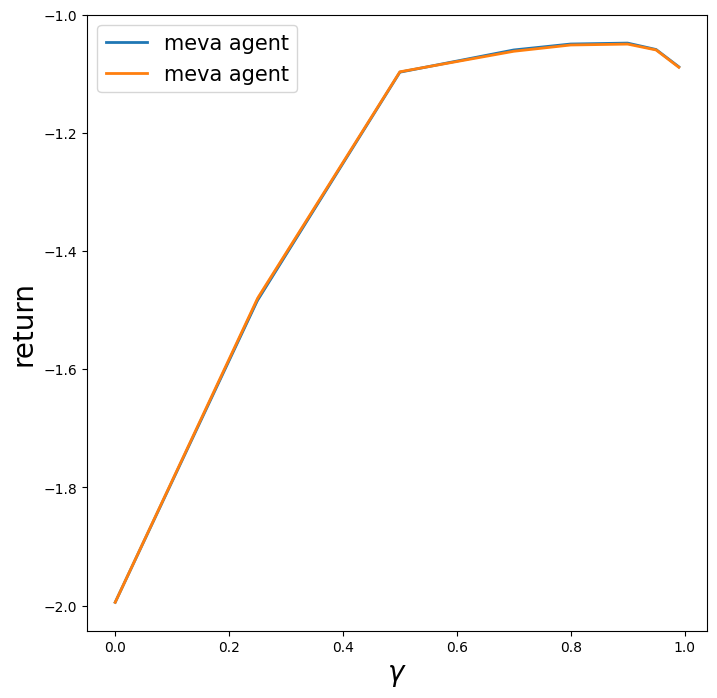

In [27]:
def plot_returnpair(ax, ys, ylabel=False):
  ys = ys.reshape([len(Analysis.gammas), ys[0,:,:,0].size, 2])  # ravel seed/batch
  mu = ys.mean(axis=1)
  sem = ys.std(axis=1)/ys.shape[1]**0.5
  qs = np.stack([mu-sem, mu, mu+sem])
  ax.plot(Analysis.gammas, qs[1], linewidth=2)
  for i in range(2):
    ax.fill_between(Analysis.gammas, qs[0,:,i], qs[2,:,i], alpha=0.5)
  ax.set_xlabel("$\\gamma$", fontsize=20)
  if ylabel: ax.set_ylabel("return", fontsize=20)
  #ax.set_ylim((-2,-1)); ax.set_xlim((0,1))

fig, axes = plt.subplots(1,1,sharex=True, sharey=True, figsize=(8,8), squeeze=False)
plot_returnpair(axes[0,0], Analysis.returns["agents"], ylabel=True)
axes[0,0].legend(["meva agent", f"{OPPONENT} agent"], fontsize=15, loc="upper left")

In [28]:
def print_returnpair(gammastr="0.95"):
  ys = Analysis.returns["agents"][Analysis.gammastrs.index("95")]
  print(ys.mean(axis=(0,1)), "+-", ys.std(axis=(0,1))/ys[:,:,0].size**0.5)
print_returnpair()

[-1.058699  -1.0594438] +- [0.00073899 0.00074475]


In [29]:
%%script echo skipping

# plot payoff polytopes to show ZD-ness
def plot_polytope(ax, agents):
  ## plot general payoff polytope
  # need to reorder payoffs to get a nice cycle
  ax.plot(PAYOFFS[(0,1,3,2,0),1], PAYOFFS[(0,1,3,2,0),0], color="gray", linewidth=1)
  #ax.set_xlim((-3,0)); ax.set_ylim((-3,0))
  ax.set_aspect("equal")
  ## plot payoff range for any value of agents[1], conditioned on agents[0]
  potential = (jax.vmap(lambda opponent: play_episode(jp.stack([agents[0], opponent]))["returns"])
               (-5 + 10*rax.uniform(rax.PRNGKey(1), shape=[1000,5])))
  ax.scatter(potential[:,1], potential[:,0], c="tab:blue", alpha=0.05)
  ## plot actual agents[1] payoff
  actual = play_episode(agents)["returns"]
  ax.axhline(actual[0], c="gray", linewidth=1)
  ax.axvline(actual[1], c="gray", linewidth=1)
  ax.scatter(actual[1], actual[0], c="tab:orange")
  ax.set_xticks([-3,-2,-1,0])
  ax.set_yticks([-3,-2,-1,0])

# prepare a figure for publication
fig, axes = plt.subplots(6,4,sharex=True,sharey=True,figsize=(12,18))
for i in range(axes.shape[0]):
  for j in range(axes.shape[1]):
    t = [0,5,10,20,35,50][i]
    plot_polytope(axes[i,j], Analysis.trails["95"]["agents"][j,1,t])
    if j == 0:
      axes[i,j].set_ylabel("return of meva", fontsize=12)
    if i == axes.shape[0]-1:
      axes[i,j].set_xlabel(f"return of {OPPONENT}", fontsize=12)
    axes[i,j].set_title(f"seed {j} time {t}")

skipping


# LOLA/naive tournament

The above cells metaplay meva vs naive/lola/meva. This section plays naive/lola combinations to complete the tournament table.

In [30]:
%%script echo skipping

# curry play_episode so we can change the game right here
lola_analysis_game = "ipd"
lola_play_episode = partial(play_episode, payoffs=PAYOFF_MATRICES[lola_analysis_game])
lola_analysis_batch_size = analysis_batch_size  # no different seeds, so use more samples
lola_analysis_lr = dict(chicken=1,
                        ipd=1/(1-GAME_DISCOUNT),
                        imp=1/(1-GAME_DISCOUNT))[lola_analysis_game]
lola_analysis_alpha = lola_analysis_lr

def train_lolas(rng, alphas):
  def init_agents(rng, batch_shape=()):
    return rax.normal(rng, shape=[*batch_shape,2,5])
  agents = init_agents(rng, [lola_analysis_batch_size])
  trail = [agents]
  for step in range(500):
    agents = _train_lolas_step(agents, alphas)
    trail.append(agents)
  return jp.stack(trail, axis=1) #[batch,time,2,5]
@jax.jit
@partial(jax.vmap, in_axes=(0,None))
def _train_lolas_step(agents, alphas):
  def f(x):
    return lola_play_episode(x)["returns"]
  def f_lola(x):  # like global f_lola but with vector of alphas
    x_extra = x + alphas[::-1,None] * naive_gradients(f)(x)
    return jp.stack([
        f(jp.stack([x[0], x_extra[1]]))[0],
        f(jp.stack([x_extra[0], x[1]]))[1],
    ])

  grads = naive_gradients(f_lola)(agents)
  agents = agents + lola_analysis_lr * grads
  return agents

def lola_print_returnpair(xs):
  ys = jax.vmap(lola_play_episode)(xs)["returns"]
  print(ys.mean(axis=0), "+-", ys.std(axis=0)/ys.shape[0]**0.5)

class LOLAAnalysis:
  nn = train_lolas(rax.PRNGKey(1), jp.array([0,0]) * lola_analysis_alpha)
  nl = train_lolas(rax.PRNGKey(1), jp.array([0,1]) * lola_analysis_alpha)
  #ln = train_lolas(rax.PRNGKey(1), jp.array([1,0]) * lola_analysis_alpha)
  ll = train_lolas(rax.PRNGKey(1), jp.array([1,1]) * lola_analysis_alpha)

  lola_print_returnpair(nn[:,-1])
  lola_print_returnpair(nl[:,-1])
  lola_print_returnpair(ll[:,-1])


skipping
